# Use PVLIB to convert Himwari irradiance to PV output

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pvlib
import numpy as np
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import os
from pathlib import Path

import sys

import xarray as xr

ERROR 1: PROJ: proj_create_from_database: Open of /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/share/proj failed


In [2]:
# get the module and inverter specifications from SAM
sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')
sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
inverter = sapm_inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

In [121]:
# load in an example day of data
day = '15'
month = '03'
year = '2021'
directory=Path(f'/g/data/rv74/satellite-products/arc/der/himawari-ahi/solar/p1s/v1.1/{year}/{month}/{day}')
files = sorted(str(p) for p in directory.rglob("*.nc"))

dataset = xr.open_mfdataset(files, decode_coords='all')

In [122]:
dataset

<xarray.Dataset> Size: 27GB
Dimensions:                     (time: 103, latitude: 1726, longitude: 2214)
Coordinates:
  * time                        (time) datetime64[ns] 824B 2021-03-14T18:30:0...
  * latitude                    (latitude) float32 7kB -44.5 -44.48 ... -10.0
  * longitude                   (longitude) float32 9kB 112.0 112.0 ... 156.3
    crs                         int32 4B -2147483647
Data variables:
    surface_global_irradiance   (time, latitude, longitude) float64 3GB dask.array<chunksize=(1, 10, 2214), meta=np.ndarray>
    direct_normal_irradiance    (time, latitude, longitude) float64 3GB dask.array<chunksize=(1, 10, 2214), meta=np.ndarray>
    surface_diffuse_irradiance  (time, latitude, longitude) float64 3GB dask.array<chunksize=(1, 10, 2214), meta=np.ndarray>
    quality_mask                (time, latitude, longitude) float64 3GB dask.array<chunksize=(1, 10, 2214), meta=np.ndarray>
    cloud_type                  (time, latitude, longitude) float32 2GB dask.array<chunksize=(1, 10, 2214), meta=np.ndarray>
    cloud_optical_depth         (time, latitude, longitude) float64 3GB dask.array<chunksize=(1, 10, 2214), meta=np.ndarray>
    solar_elevation             (time, latitude, longitude) float64 3GB dask.array<chunksize=(1, 10, 2214), meta=np.ndarray>
    solar_azimuth               (time, latitude, longitude) float64 3GB dask.array<chunksize=(1, 10, 2214), meta=np.ndarray>
    julian_date                 (time, latitude, longitude) float64 3GB dask.array<chunksize=(1, 10, 2214), meta=np.ndarray>
Attributes: (12/58)
    Conventions:                      CF-1.7
    Metadata_Conventions:             Unidata Dataset Discovery v1.0
    acknowledgment:                   The following acknowledgement is requir...
    cdm_data_type:                    grid
    comment:                          Solar radiation data derived from satel...
    contributor_name:                 Mines ParisTech; Commonwealth of Austra...
    ...                               ...
    quality:                          0
    quality_meaning:                  0: no_known_issues 1: known_issue 
    project:                          Gridded Solar Observations
    history:                          Mon Mar  4 01:55:06 2024: ncatted -a re...
    references:                       Poulsen C., Majewski L. J. (2022) Gridd...
    NCO:                              netCDF Operators version 4.7.7 (Homepag...

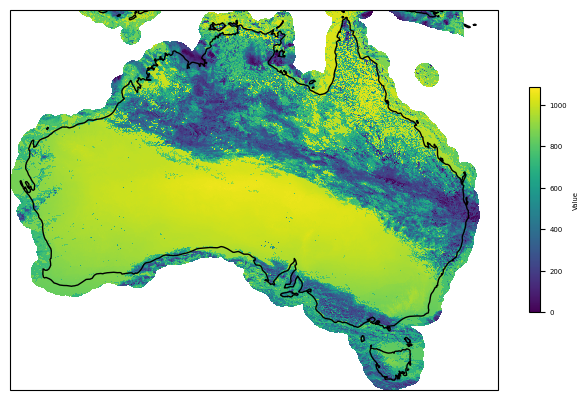

In [123]:
# Read the variables
data = dataset.sel(time=f'{year}-{month}-{day}-T2:50')
latitudes = data.variables['latitude'][:]
longitudes = data.variables['longitude'][:]
irradiance = np.squeeze(data.variables['surface_global_irradiance'][:,:])

# Create a figure
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

mesh=ax.pcolormesh(longitudes, latitudes, irradiance, cmap='viridis',vmin=0, transform=ccrs.PlateCarree())

ax.coastlines()
cbar = plt.colorbar(mesh,ax=ax,shrink=0.5)
cbar.ax.tick_params(labelsize=5)  # Set the font size for the colorbar ticks
cbar.set_label('Value', fontsize=5) 
 
plt.tight_layout()

plt.show()

In [124]:
# # apply REZ mask to data, removes spatial regions note relevant to solar PV gen
# mask_file = "/home/548/cd3022/aus-historical-solar-droughts/data/boundary_files/REZ_mask.npz"
# loaded_mask = np.load(mask_file)
# mask = loaded_mask["mask"]
# mask_da = xr.DataArray(mask, coords={"latitude": dataset.latitude, "longitude": dataset.longitude}, dims=["latitude", "longitude"])
# masked_ds = dataset.where(mask_da, drop=True)

In [125]:
# # Read the variables
# data = masked_ds.sel(time='2020-05-05-T04:00')
# latitudes = data.variables['latitude'][:]
# longitudes = data.variables['longitude'][:]
# irradiance = np.squeeze(data.variables['surface_global_irradiance'][:,:])

# # Create a figure
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# mesh=ax.pcolormesh(longitudes, latitudes, irradiance, cmap='viridis',vmin=0, transform=ccrs.PlateCarree())

# ax.coastlines()
# cbar = plt.colorbar(mesh,ax=ax,shrink=0.5)
# cbar.ax.tick_params(labelsize=5)  # Set the font size for the colorbar ticks
# cbar.set_label('Value', fontsize=5) 
 
# plt.tight_layout()

# plt.show()

In [126]:
S7 = (-30.6, 136.9)
Q2 = (-19.0, 144.0)
N3 = (-32.0, 148.8)
Q8 = (-27.6, 151.4)
HBA = (-42.9, 147.4)
CY = (-10.7, 142.6)
SC = (-43.6, 146.8)

zone = CY

lat = zone[0]
lon = zone[1]
single_point = dataset.sel(latitude=lat, longitude=lon)

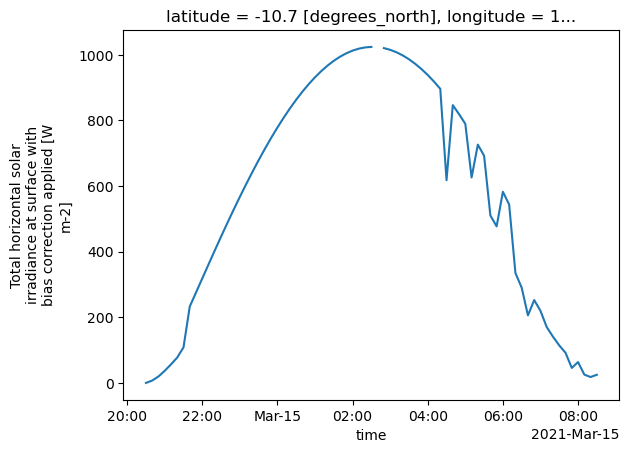

In [127]:
single_point.surface_global_irradiance.plot()

In [128]:
# get variables for solar pv model calculations
ghi = single_point.surface_global_irradiance.values.ravel()
dni = single_point.direct_normal_irradiance.values.ravel()
dhi = single_point.surface_diffuse_irradiance.values.ravel()

# # Remove nans
# nan_mask = np.isnan(ghi) # same for all vars

# ghi_clean = ghi[~nan_mask]
# dni_clean = dni[~nan_mask]
# dhi_clean = dhi[~nan_mask]

# # get correct time and coordinate data, so that it matches up with the remaining irradiance values
# lat_1d = masked_ds.latitude.values
# lon_1d = masked_ds.longitude.values

# lon_grid, lat_grid = np.meshgrid(lon_1d, lat_1d, indexing="xy")
# lat_grid_1d = lat_grid.ravel()
# lon_grid_1d = lon_grid.ravel()

# # repeat/tile the coordinates so they line up with each individual data point
# lat_1d_expanded = np.tile(lat_grid_1d, dataset.sizes["time"])
# lon_1d_expanded = np.tile(lon_grid_1d, dataset.sizes["time"])
# time_1d = np.repeat(masked_ds.time.values, len(lat_grid_1d)) 

# lat_1d_expanded_clean = lat_1d_expanded[~nan_mask]
# lon_1d_expanded_clean = lon_1d_expanded[~nan_mask]
# time_1d_clean = time_1d[~nan_mask]
time = single_point.time.values

# Compute solar position for all grid cells at once
solpos = pvlib.solarposition.get_solarposition(
    time,
    lat,
    lon
)

# find the angle of incidence of the sun on the panel for a single-axis tracking system
tracking = pvlib.tracking.singleaxis(
    apparent_zenith=solpos["apparent_zenith"],
    apparent_azimuth=solpos["azimuth"]
)

airmass_relative = pvlib.atmosphere.get_relative_airmass(
    solpos['apparent_zenith'].values
)
airmass_absolute = pvlib.atmosphere.get_absolute_airmass(
    airmass_relative,
)

total_irradiance = pvlib.irradiance.get_total_irradiance(
    surface_tilt=tracking['surface_tilt'],
    surface_azimuth=tracking['surface_azimuth'],
    dni=dni,
    ghi=ghi,
    dhi=dhi,
    solar_zenith=solpos['apparent_zenith'].values,
    solar_azimuth=solpos['azimuth'].values
)

effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
    poa_direct=total_irradiance['poa_direct'],
    poa_diffuse=total_irradiance['poa_diffuse'],
    airmass_absolute=airmass_absolute,
    aoi=tracking['aoi'],
    module=module,
)

# function for linke turbidity does not work for array of data, currently using approximation instead

# compute clear sky irradiances for ideal condition generation calculations
# linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(
#     time_1d_clean,
#     lat_1d_expanded_clean.flatten(),
#     lon_1d_expanded_clean.flatten()
# )

# Approximation of linke_turbidity for clearsky irradiance calculations
linke_turbidity = np.maximum(2 + 0.1 * airmass_absolute, 2.5)
# linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(
#     time=pd.to_datetime(time),
#     latitude=lat,
#     longitude=lon,
#     interp_turbidity=True
# )
doy = pd.to_datetime(time).dayofyear
dni_extra = pvlib.irradiance.get_extra_radiation(doy)
ideal_conditions = pvlib.clearsky.ineichen(
    apparent_zenith=solpos['apparent_zenith'].values,
    airmass_absolute=airmass_absolute,
    linke_turbidity=linke_turbidity,
    dni_extra=dni_extra
)
ideal_total_irradiance = pvlib.irradiance.get_total_irradiance(
    surface_tilt=tracking['surface_tilt'],
    surface_azimuth=tracking['surface_azimuth'],
    dni=ideal_conditions['dni'],
    ghi=ideal_conditions['ghi'],
    dhi=ideal_conditions['dhi'],
    solar_zenith=solpos['apparent_zenith'].values,
    solar_azimuth=solpos['azimuth'].values
)
    
ideal_effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
    poa_direct=ideal_total_irradiance['poa_direct'],
    poa_diffuse=ideal_total_irradiance['poa_diffuse'],
    airmass_absolute=airmass_absolute,
    aoi=tracking['aoi'],
    module=module,
)

# Compute power
dc = pvlib.pvsystem.sapm(
    effective_irradiance=effective_irradiance.values,
    temp_cell=np.full_like(effective_irradiance, 18), # assume temperature of 18 deg C
    module=module
)

ac = pvlib.inverter.sandia(
    v_dc=dc['v_mp'],
    p_dc=dc['p_mp'],
    inverter=inverter
)
ac_QC = np.where(ac < 0, np.nan, ac)

rated_capacity = module.loc['Impo'] * module.loc['Vmpo']
cf = ac_QC/rated_capacity # capacity factor

dc_ideal = pvlib.pvsystem.sapm(
    effective_irradiance=ideal_effective_irradiance.values,
    temp_cell=np.full_like(effective_irradiance, 18), # assume temperature of 18 deg C
    module=module
)
ac_ideal = pvlib.inverter.sandia(
    v_dc=dc_ideal['v_mp'],
    p_dc=dc_ideal['p_mp'],
    inverter=inverter
)
ac_ideal_QC = np.where(ac_ideal < 0, np.nan, ac_ideal)

# ratio between actual observed possible solar PV generation (given the satellite irradiance)
# and the theoretical generation in clearsky conditions
performance_ratio = ac_QC / ac_ideal_QC

### Get solar PV generation data back into lat/lon/time 3D array

In [129]:
# # make empty array of same length of original data
# ac_filled = np.empty_like(ghi)
# ac_filled[nan_mask] = np.nan

# # Use the same mask that was used to originally used to remove nans, to now add data back
# # Array should now have same 1D pattern of values and nan
# ac_filled[~nan_mask] = ac_QC

# # template to use with correct shape
# mask_template = masked_ds.surface_global_irradiance
# # full_template = dataset.surface_global_irradiance

# # apply template to the filled 1D data to fit it back to 3D shape
# ac_reshaped = ac_filled.reshape(mask_template.shape)
# ac_xarray = xr.DataArray(ac_reshaped, coords=mask_template.coords, dims=mask_template.dims)

# # Same process, but for the clearsky data
# ideal_filled = np.empty_like(ghi)
# ideal_filled[nan_mask] = np.nan
# ideal_filled[~nan_mask] = ac_ideal_QC

# ideal_reshaped = ideal_filled.reshape(mask_template.shape)
# ideal_xarray = xr.DataArray(ideal_reshaped, coords=mask_template.coords, dims=mask_template.dims)

In [110]:
rated_capacity

219.656729124

# Compare ideal vs observation

Text(0, 0.5, 'Irradiance (W/m2)')

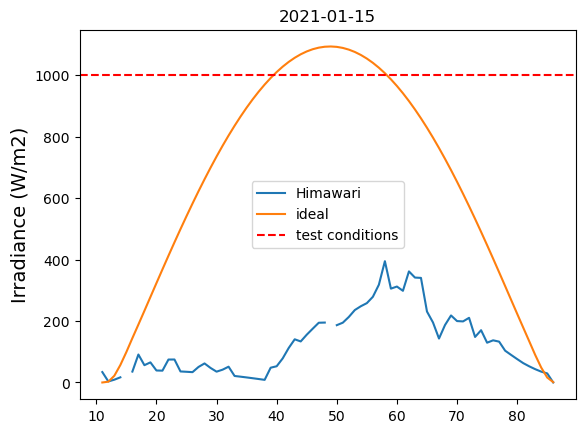

In [114]:
him_ghi = single_point.surface_global_irradiance.data
ideal_data = ideal_conditions['ghi']
plt.plot(him_ghi, label='Himawari')
plt.plot(ideal_data, label='ideal')
plt.axhline(1000, color='r', linestyle='--', label='test conditions')
plt.legend()
plt.title(f'{year}-{month}-{day}')
# plt.axvline(32, color='purple', linestyle=':')
plt.ylabel('Irradiance (W/m2)', fontsize = 14)

Text(0.5, 1.0, '2021-01-04')

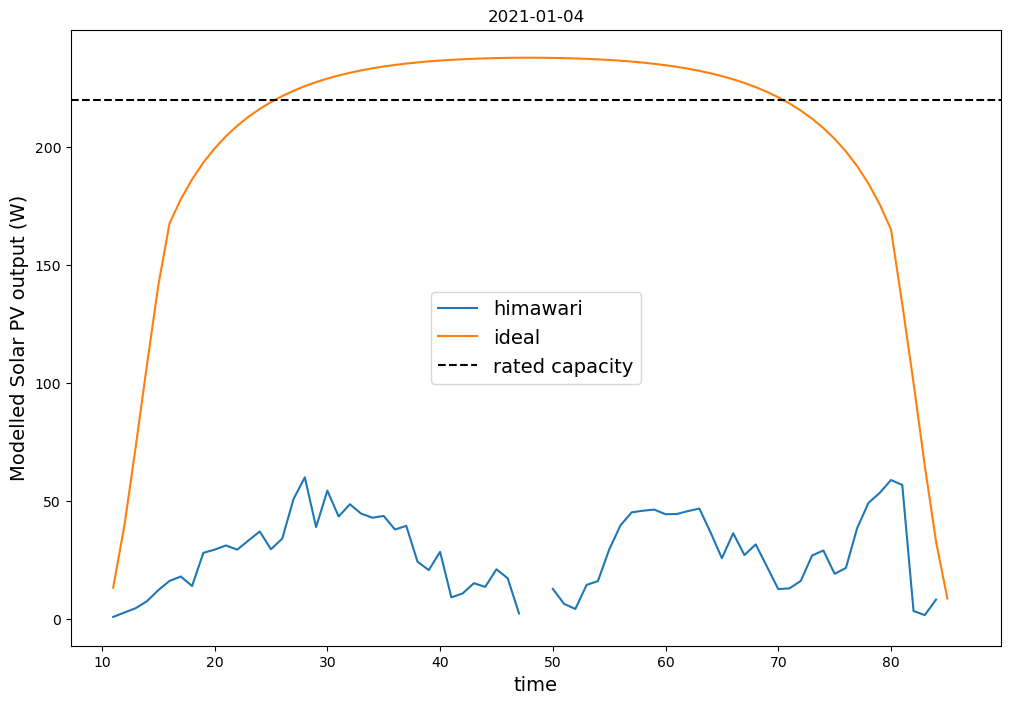

In [17]:
plt.figure(figsize=(12,8))
plt.plot(ac_QC, label='himawari')
plt.plot(ac_ideal_QC, label='ideal')
plt.axhline(rated_capacity, color='black', linestyle='--', label='rated capacity')
plt.legend(fontsize=14)
plt.xlabel('time', fontsize=14)
plt.ylabel('Modelled Solar PV output (W)', fontsize=14)
# plt.axvline(32, color='purple', linestyle=':')
plt.title(f'{year}-{month}-{day}')

In [18]:
ac_QC[33] - ac_QC[32]

-3.9936708305985107

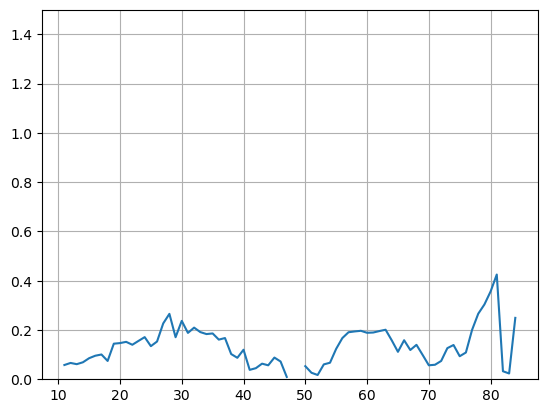

In [19]:
plt.plot(ac_QC/ac_ideal_QC)
plt.ylim(0,1.5)
plt.grid(True)

In [20]:
# plot of the ideal vs actual generation daily profile
plt.figure(figsize=(12,8))
ac_xarray.sel(latitude=-20.5, longitude=144.2).plot()
ideal_xarray.sel(latitude=-20.5, longitude=144.2).plot()

NameError: name 'ac_xarray' is not defined

<Figure size 1200x800 with 0 Axes>

In [ ]:
# same process again, but using the ratio of actual vs ideal
pr_filled = np.empty_like(ghi)
pr_filled[nan_mask] = np.nan
pr_filled[~nan_mask] = performance_ratio

pr_reshaped = pr_filled.reshape(mask_template.shape)
pr_xarray = xr.DataArray(pr_reshaped, coords=mask_template.coords, dims=mask_template.dims)

In [ ]:
# Plot of this daily ratio
pr_xarray.sel(latitude=-20.5, longitude=144.2).plot()

In [ ]:
# Plot of the solar pv generation data, fitted back onto grid
# so can be compared with above unprocessed irradiance data

lat = pr_xarray.latitude
lon = pr_xarray.longitude
plot_data = pr_xarray.sel(time='2017-02-09T21:30:00')

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

mesh=ax.pcolormesh(lon, lat, plot_data, cmap='viridis',vmin=0, transform=ccrs.PlateCarree())

ax.coastlines()
cbar = plt.colorbar(mesh,ax=ax,shrink=0.5)
cbar.ax.tick_params(labelsize=5)  # Set the font size for the colorbar ticks
cbar.set_label('Value', fontsize=5) 
 
plt.tight_layout()

plt.show()